Clustering
=========

Dado que la mayoría de las variables a analizar revisten de carácter categórico, no es recomendable aplicar una técnica de clustering tradicional (ej: K-means) ni tampoco PCA, ya que utilizan distancias euclideas y las mismas no tienen un significado de valor con variables nominales y binarias.

Por eso, se decide aplicar un análisis de correspondencia múltiple que es compatible con variables categóricas y permite encontrar variables latentes que capturan la varianza de los datos en un espacio de variables con menor dimensión. Estas mismas variables al graficarlas nos permitirán encontrar clusters entre los individuos analizados.

In [1]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

%matplotlib inline

In [77]:
# Cargamos archivo .txt separado por "|"
# Se considera el valor 9999 como nulo
original_data = pd.read_table('ENFR2013_baseusuario.txt', sep='|', na_values=9999)

/home/despegar/sparkData/miniconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [78]:
# Columnas a seleccionar
selected_cols = [col for col in original_data if col.startswith('BIAF')] + ['NIVEL_ACTIVIDAD_FISICA']
# Seleccionamos esas columnas
selected_data = original_data[selected_cols]

In [79]:
# Dimensiones del dataset
selected_data.shape

(32365, 14)

#### Datos faltantes

In [47]:
# Inspección de datos faltantes
selected_data.isnull().sum()

BIAF01                        0
BIAF02                    25925
BIAF03                        0
BIAF04                    23648
BIAF05                        0
BIAF06                    12456
BIAF07                     1643
BIAF08                    24106
BIAF09                     8259
BIAF10_01                  8259
BIAF10_02                  8259
BIAF10_03                  8259
BIAF10_04                  8259
NIVEL_ACTIVIDAD_FISICA      269
dtype: int64

Dado que son pocos y no es posible inferir su valor, se descartan los casos donde "NIVEL_ACTIVIDAD_FISICA" es nulo.

In [80]:
selected_data = selected_data[selected_data['NIVEL_ACTIVIDAD_FISICA'].notnull()]

Existen 5 variables con la misma cantidad de nulos. Al mirar con mayor detalle, se verifica que
fueron personas que declararon no haber realizado actividad física, por lo que no era posible
contestar dichas variables. Se les asigna la categoría "Sin actividad" y 0 minutos de actividad física.

In [5]:
selected_data[selected_data['BIAF10_01'].isnull()].groupby(['BIAF01','BIAF03','BIAF05']).agg('count')

,,,BIAF02,BIAF04,BIAF06,BIAF07,BIAF08,BIAF09,BIAF10_01,BIAF10_02,BIAF10_03,BIAF10_04,NIVEL_ACTIVIDAD_FISICA
BIAF01,BIAF03,BIAF05,,,,,,,,,,,
8,8,8,0,0,0,7625,8259,0,0,0,0,0,8259


In [81]:
selected_data.loc[selected_data['BIAF10_01'].isnull(), ['BIAF02','BIAF04','BIAF06']] = 0
selected_data.loc[selected_data['BIAF10_01'].isnull(), ['BIAF09','BIAF10_01','BIAF10_02','BIAF10_03','BIAF10_04']] = 3

Para los valores nulos en variables numéricas como los minutos de actividad física se utiliza la nomenclatura proporcionada por el diccionario del INDEC: 9999.

In [82]:
selected_data.loc[selected_data['BIAF02'].isnull(), ['BIAF02']] = 9999
selected_data.loc[selected_data['BIAF04'].isnull(), ['BIAF04']] = 9999
selected_data.loc[selected_data['BIAF06'].isnull(), ['BIAF06']] = 9999
selected_data.loc[selected_data['BIAF07'].isnull(), ['BIAF07']] = 9999
selected_data.loc[selected_data['BIAF08'].isnull(), ['BIAF08']] = 11

In [43]:
selected_data.isnull().sum()

BIAF01                    0
BIAF02                    0
BIAF03                    0
BIAF04                    0
BIAF05                    0
BIAF06                    0
BIAF07                    0
BIAF08                    0
BIAF09                    0
BIAF10_01                 0
BIAF10_02                 0
BIAF10_03                 0
BIAF10_04                 0
NIVEL_ACTIVIDAD_FISICA    0
dtype: int64

#### Corrección tipos de datos

Por default los datos son considerados cuantitativos, sin embargo, sabemos que deben ser nominales o binarios, excepto por "BIAF02", "BIAF04", "BIAF06" y "BIAF07" quienes serán discretizados para convertirlos en datos categóricos.

In [53]:
selected_data.dtypes

BIAF01                      int64
BIAF02                    float64
BIAF03                      int64
BIAF04                    float64
BIAF05                      int64
BIAF06                    float64
BIAF07                    float64
BIAF08                    float64
BIAF09                    float64
BIAF10_01                 float64
BIAF10_02                 float64
BIAF10_03                 float64
BIAF10_04                 float64
NIVEL_ACTIVIDAD_FISICA    float64
dtype: object

#### Discretización de variables continuas

Por simplicidad, se discretiza las variables medidas en minutos en 0 minutos, 0 a 9998 minutos y 9999 (que significa que no contestó). Las variables referidas a cantidad de días en la semana se discretizaron en 1 a 3 días, 4 a 5 días, 6 a 7 días y 8 (significa que no realizó). Podría existir un mejor criterio si es que se posse mayor conocimiento en el área que permita definir otros cortes.

Los nulos seguirán considerándose como tales como una categoría propia.

In [83]:
# Variables medidas en minutos a la semana
cols_to_discretize = ['BIAF02','BIAF04','BIAF06','BIAF07']

In [84]:
for col in cols_to_discretize:
    selected_data[col + '_d'] = pd.cut(selected_data[col], bins=[-1,1,9998,9999])
    selected_data[col + '_d'] = selected_data[col + '_d'].astype(str)

In [85]:
# Variables medidas en días a la semana
cols_to_discretize2 = ['BIAF01','BIAF03','BIAF05']

In [86]:
for col in cols_to_discretize2:
    selected_data[col + '_d'] = pd.cut(selected_data[col], bins=[0, 3, 5, 7, 8])
    selected_data[col + '_d'] = selected_data[col + '_d'].astype(str)

In [87]:
selected_data['BIAF01_d'].value_counts()

(7, 8]    25716
(0, 3]     4379
(3, 5]     1181
(5, 7]      820
Name: BIAF01_d, dtype: int64

#### Convertir variables continuas en categóricas

Por default, Python las reconoce como variables númericas, sin embargo, sabemos que se trata de una codificación de variables nominales. Por ende, las trataremos como tales.

In [88]:
for col in selected_data.columns.difference(cols_to_discretize):
    selected_data[col] = pd.Categorical(selected_data[col])

In [89]:
# Eliminamos aquellas columnas originales que ya fueron discretizadas
selected_data.drop(['BIAF01','BIAF02', 'BIAF03','BIAF04','BIAF05','BIAF06', 'BIAF07'], axis=1, inplace=True)

### Análisis de Correspondencia Múltiple

In [39]:
import prince

In [98]:
mca = prince.MCA(n_components=2, n_iter=3, copy=True, check_input=True, engine='auto', random_state=42)
mca = mca.fit(selected_data)

/home/despegar/sparkData/miniconda2/envs/py3/lib/python3.6/site-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/home/despegar/sparkData/miniconda2/envs/py3/lib/python3.6/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/home/despegar/sparkData/miniconda2/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

Se utilizaron sólo 2 componentes, ya que el de mayor magnitud sólo logró explicar el 21% de la varianza de los datos, mientras que el segundo componente sólo un 6%.

In [99]:
mca.explained_inertia_

[0.21373011066486133, 0.06393841975344473]

En el siguiente gráfico se recomienda leerlo tomando como clase la variable "NIVEL_ACTIVIDAD_FISICA".
Las características que se alojan cercanas a NIVEL_ACTIVIDAD_FISICA_1, NIVEL_ACTIVIDAD_FISICA_2 Y NIVEL_ACTIVIDAD_FISICA_3 presentan una correlación alta con estas categorías. 
Por ende, se puede inferir: 

Para personas con nivel de actividad intenso (NIVEL_ACTIVIDAD_FISICA_1):
- Suelen realizar actividades intensas y moderadas desde 1 a 7 días a la semana. (BIAF01_d y BIAF03_d)
- Suelen realizar actividades intensas durante más de 0 minutos a la semana. (BIAF02_d)
- Suelen considerar que realizan la cantidad de ejercicio necesitada. (BIAF_09_1.0)

Para personas con nivel de actividad moderado (NIVEL_ACTIVIDAD_FISICA_2):
- No suelen realizar actividades por falta de instalaciones, razones de salud, no le interesa. (BIAF09)
- Los ejercicios físicos fueron parte de su actividad doméstica y laboral. (BIAF10_01 y BIAF10_02)
- No realizan ejercicio por falta de seguridad. (BIAF08)

Para personas con nivel de actividad bajo (NIVEL_ACTIVIDAD_FISICA_3):
- No suelen responder a la cantidad de tiempo que están sentados. (BIAF07_d)
- Responden no realizar actividades intensas, ni moderadas ni tampoco caminar. (BIAF01_d, BIAF03_d y BIAF05_d)
- No suelen realizar ejercicio por todas las razones disponibles, excepto por falta de seguridad. (BIAF08)

/home/despegar/sparkData/miniconda2/envs/py3/lib/python3.6/site-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/home/despegar/sparkData/miniconda2/envs/py3/lib/python3.6/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/home/despegar/sparkData/miniconda2/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

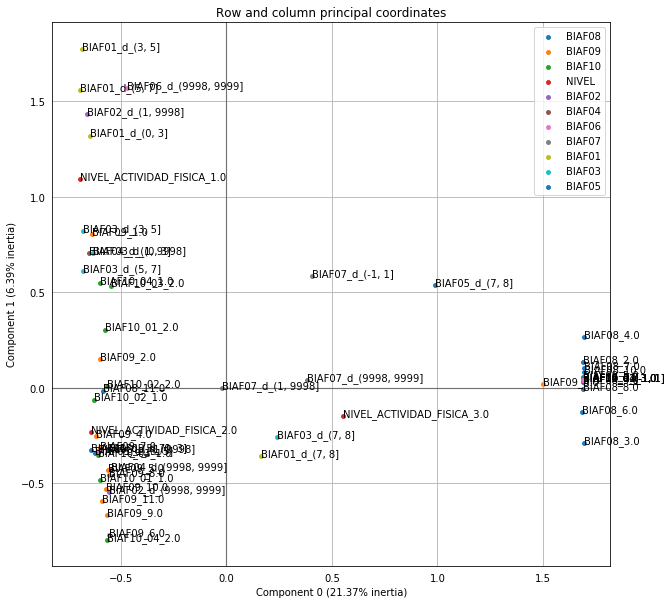

In [100]:
ax = mca.plot_coordinates(
     X=selected_data,
     ax=None,
     figsize=(10, 10),
     show_row_points=False,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=True,
     legend_n_cols=1
 )